In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1

Какую задачу решает метод максимума правдоподобия?

Оценка «наиболее подходящих параметров» выбранного нами распределения по имеющейся выборке

Важно помнить, ММП не подбирает само распределение, а подбирает параметры для конкретного распределения.

### 2

Что такое правдоподобие из метода максимума правдоподобия?

Вероятность встретить выборку, с которой мы работаем, при условии конкретных параметров выбранного нами распределения

$$L(X^n, \theta) = \prod_{i=1}^{n} f(X_i, \theta)$$

f — плотность (для непрерывных) или вероятность (для дискретных)

Ещё иногда говорят "вероятность увидеть то, что мы увидели".

### 3

Представим, что у вас есть небольшая выборка и вы знаете, что она пришла из нормального распределения с неизвестными параметрами. Мы хотим восстановить значение параметра среднего с помощью метода максимума правдоподобия.

xs = [5, 6.4, 7, 5.5, 8, 4.9, 6.2]

Попробуйте записать правдоподобие на листочке, логарифмировать его и найти его максимум через дифференцирование и приравнивание производной к 0.

Вычислите по этой формуле значение параметра. Что у вас получилось?

**Решение**

Если посчитать производную логарифма правдоподобия и приравнять к 0, то можно выразить неизвестный нам параметр среднего, который окажется равным среднему значению выборки. 

Сначала распишем правдоподобие:

$$\log p(X | \theta) = \sum_{i=1}^{N} \log \mathbb{N} (x_i | \mu, \sigma^2) = \sum_{i=1}^{N} \log \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(x_i - \mu)^2}{2 \sigma^2} \right) = \sum_{i=1}^{N} - \frac{1}{2} \log(2 \pi) - \log \sigma - \frac{(x_i - \mu)^2}{2 \sigma^2}$$

Придифференцируем по $\mu$:

$$\nabla_{\mu} \log p(X | \theta) = \nabla_{\mu} \sum_{i=1}^{N} - \frac{(x_i - \mu)^2}{2 \sigma^2} = \sum_{i=1}^{N} \frac{(x_i - \mu)}{\sigma^2}$$

Приравняем производную к 0:

$$\sum_{i=1}^{N} \frac{(x_i - \mu)}{\sigma^2} = 0$$

$$\sum_{i=1}^{N} (x_i - \mu) = 0$$

$$ \mu = \frac{1}{N} \sum_{i=1}^{N} x_i$$

In [2]:
np.mean([5, 6.4, 7, 5.5, 8, 4.9, 6.2])

6.142857142857143

### 4

Не всегда метод максимума правдоподобия можно применить так, чтобы найти аналитическое решение, то есть формулу для поиска параметров распределения по выборке.

Альтернативный вариант — использование методов оптимизации, в который можно подать оптимизируемый функционал и опционально его градиент, чтобы алгоритмы нашли для нас точку оптимума.

Давайте попробуем это сделать. Снова вернёмся к известной нам выборке со средними ценами на дома:

Постройте гистограмму медианного дохода (MedInc), чтобы оценить, на какое распределение похожа эта случайная величина. На какое распределения более всего похоже наше распределение? Если вы не помните или не знаете какое-то из распределений, можете прочитать про него подробнее на Википедии и увидеть иллюстрации.

In [3]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True, return_X_y=True)
df, target = data[0], data[1] 

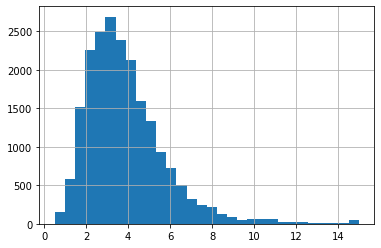

In [4]:
df.MedInc.hist(bins=30)
plt.show()

Это несимметричное распределение непрерывной случайной величины, поэтому это не может быть нормальным и биномиальным распределением. Распределение Сьюдента также симметрично и похоже на нормальное. 

Логнормальное распределение наиболее похоже на наше.

### 5

Кроме логнормального распределения сюда подходит ещё и гамма-распределение. Давайте найдём параметры распределения под нашу выборку. У него есть два основных параметра, хотя в версии из scipy вводят также сдвиг (loc). Мы его будем полагать равным 0 (тогда носитель распределение, то есть возможные значения — положительные числа), а другие два: a, scale — будем искать. 

Для этого сначала реализуйте функцию, которая будет вычислять логарифм правдоподобия для нашей выборки. Вам понадобится распределения gamma из библиотеки scipy. Функция должна принимать на вход один аргумент, в котором будут расположены все нужные вам параметры. 

Далее воспользуйтесь функцией minimize из модуля optimize библиотеки scipy. Там реализованы методы оптимизации. Укажите вашу функцию для вычисления логарифма правдоподобия, начальное значение ваших параметров и метод L-BFGS-B.

В качестве начального приближения возьмите a=1, scale=2. Если становится сложно, то воспользуйтесь похожим примером из лекции. Имейте в виду, что здесь мы не указываем, как рассчитывается градиент и гессиан (вторая производная) для нашей функции, поэтому они будут рассчитываться численно, что обычно плохо сказывается на процессе оптимизации.

Для проверки нарисуйте на одном графике гистограмму вашей случайной величины и плотность распределения с настроенными параметрами (метод pdf для расчёта плотности, а в качестве точек можно точки с равномерной сетки с помощью np.linspace). Должны получаться похожие картинки.

Какие значения параметров вы получили?

**Решение**

Сначала напишем функцию для расчёта правдоподобия, для этого используем сразу функцию для логарифма плотности гамма-распределения, не забудем знак минуса, потому что далее мы будем использовать функцию для минимизации, а правдоподобие надо максимизировать.

In [5]:
from scipy.stats import gamma

def calc_LL(theta):
    a, scale = theta
    LL = np.sum(gamma.logpdf(df.MedInc, a=a, loc=0, scale=scale))
    return -LL

In [6]:
from scipy.optimize import minimize

theta = [1, 2]
solution = minimize(calc_LL, theta, method='L-BFGS-B')
solution.status, solution.message, solution.x

(0,
 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 array([4.74905907, 0.81503973]))

Визуализируем на одном графике гистограмму и теоретическое распределение:

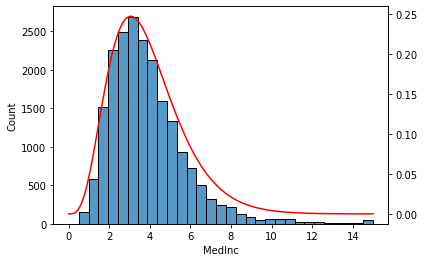

In [7]:
x = np.linspace(0, 15, 100)
p = gamma(a=solution.x[0], loc=0, scale=solution.x[1]).pdf(x)

sns.histplot(df.MedInc, bins=30)
plt.twinx()
plt.plot(x, p, color='red')
plt.show()

Видим, что действительно настроилось что-то хорошее и похожее на правду (довольно часто получается либо хорошо, либо сразу заметная дичь).

Итоговые параметры:

In [8]:
solution.x

array([4.74905907, 0.81503973])

### 6

В чем преимущества ядерного подхода к оценке плотности по сравнению с параметрическим методом максимума правдоподобия?
- Можно оценить плотность для распределения любой формы
- Более быстрое вычисление плотности для новых точек
- Мы не должны выбирать вид распределения для восстановления распределения

Ядерный подход более медленный, так как каждое вычисление плотности требует проходить по всей выборки с ядром. Параметрический подход после настройки параметров применять заметно быстрее.

В отличие от параметрического подхода, где мы должны выбрать вид распределения, ядерный подход не ограничен известными нам распределениями. При этом не надо и выбирать вид распределения заранее.

### 7

Какими параметрами задаётся ядерная оценка плотности?
- Ширина окна h
- Семейством восстанавливаемого распределения
- Точность восстановления плотности
- Функция ядра K

Точностью восстановления плотности мы не управляем, а семейство распределения выбирать не нужно — это основное преимущество ядерной оценки плотности.

### 8

Давайте попрактикумемся в ядерной оценке плотности. Для начала давайте посчитаем «руками» на простом примере (не используем библиотеки, которые решают задачу напрямую, но можем для удобства делать это в jupyter).

Пусть наша выборка представляет собой следующее:

xs = [0, 1.1, 1.4, 1.8, 2.5, 5.5, 7]

В качестве ядра возьмём ядро, представляющее собой «треугольник», то есть функцию, принимающую ненулевые значения от -1 до 1, в точке 0 значение 1, между -1 и 0 линейный рост от 0 до 1, между 0 и 1 линейное падение от 1 до 0. То есть площадь под ядром будет равна 1, h=1.

Функция для ядерной оценки с лекции:

$$\hat{\rho}_N(x) = \frac{1}{Nh} \sum_{i=1}^N K\left(\frac{X_i - x}{h}\right)$$

Посчитайте ядерную оценку плотности в точке $x=2.0$

In [9]:
xs = [0, 1.1, 1.4, 1.8, 2.5, 5.5, 7]
x0 = 2.0

Реализуем наше ядро:

In [10]:
def k(x0, x):
    if abs(x0 - x) < 1:
        return 1 - abs(x0 - x)
    return 0

Просуммируем по всем точкам и нормируем:

In [11]:
sum(k(x0, x) for x in xs) / len(xs)

0.2571428571428572

И автоматически:

In [12]:
from sklearn.neighbors import KernelDensity

kde = (
    KernelDensity(kernel="linear", bandwidth=1)
    .fit(np.array(xs).reshape((-1, 1)))
)

np.exp(kde.score_samples(np.array([x0]).reshape((-1, 1))))

array([0.25714286])

### 9

А теперь давайте попробуем воспользоваться для этого библиотечным вариантом. 

В качестве данных вернёмся к нашим привычным данным про дома.

Посчитайте ядерную оценку плотности в точке x=6 для медианного дохода с помощью sklearn.neighbors.KernelDensity с Гауссовым ядром и h=0.5. Вам понадобятся методы fit (настройка) и score_samples (применение). Учтите, что вам вернутся логарифмы оценки, так что надо от них взять экспоненту.

In [13]:
kde = (
    KernelDensity(kernel="linear", bandwidth=0.5)
    .fit(np.array(df['MedInc']).reshape((-1, 1)))
)

np.exp(kde.score_samples(np.array([6]).reshape((-1, 1))))

array([0.07392297])

### 10

Давайте проверим, действительно ли вычисленная по этой формуле величина будет плотностью распределения.

Для этого возьмите настроенную в прошлом задании оценку плотности и убедитесь, что площадь под графиком кривой оценки плотности равна единице. Это и есть условие на функцию, претендующую быть плотностью (аналогично тому, что сумма вероятностей всех возможных исходов должна давать единицу).

Для этого сгенерируйте точки на равномерной сетке с некоторым количеством точек, где левая граница будет немного левее, чем исходная выборка (можно брать с запасом), а правая — наоборот правее исходной выборки, на которой настраивалась оценка в предыдущем задании. Для этого можно построить гистограмму той величины. Для генерации будет полезен метод np.linspace.

Далее посчитайте значение плотности с помощью вашей оценки в каждой сгенерированной точке. Не спешите суммировать — в численной оценке интеграла мы каждый кусочек заменяем на прямоугольник, высота которого равна значению плотности, а ширина — расстоянию между соседними точками. Площадь под графиком будет равно площади этих столбиков. Посчитайте её и сравните с единицей.

Попробуйте разное количество точек (соответственно разное расстояние между соседними точками) — чем уже прямоугольники, тем точнее оценка на интеграл.

**Решение**

Попробуем посчитать по сетке (с небольшим запасом отступим от минимального и максимального значения, дальше считать нет смысла). Важно, что мы умножаем вычисленную плотность на ширину, то есть вычисляем площадь под графиком (явно используем тот факт, что ширина каждого кусочка одинаковая).

In [14]:
xs = np.linspace(-1, 20, 100)
sum(np.exp(kde.score_samples(xs.reshape((-1, 1)))) * (xs[1] - xs[0]))

0.9999383332087657

Увеличим число точек сетки:

In [15]:
xs = np.linspace(-1, 20, 1000)
sum(np.exp(kde.score_samples(xs.reshape((-1, 1)))) * (xs[1] - xs[0]))

0.999998424839919

Такая методика расчёта интегралов называется [численным интегрированием](https://ru.wikipedia.org/wiki/Численное_интегрирование).